### Load modules

In [2]:
# general
import os
import sys
import time
import numpy as np 
import matplotlib.pyplot as plt 
import random as rnd
import time

# Numpyro
import numpyro
import numpyro.distributions as npdist
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(4)

#JAX
import jax
import flax
from jax.tree_util import tree_map
from flax.training import train_state  # Useful dataclass to keep train state
import optax

# PyTorch
import torch
import torch.utils.data as data

# check versions
print('Pytorch version: ',   torch.__version__)
print('Numpyro version: ', numpyro.__version__)
print('JAX version:     ',     jax.__version__)
print('Flax version:    ',    flax.__version__)
print('Optax version:   ',   optax.__version__)
from platform import python_version
print('Pythorch version:',python_version())

# import priors 
#from models.priors import *

# import functions to load data
from priorCVAE.models.data import *

# import VAE architecture
from priorCVAE.models.cvae import *

# import loss functions
from priorCVAE.models.losses import *

# Test dist_euclid
#x1 = jnp.array([1,2,3])
#dist_euclid(x1,x1)

# test kl_divergence
#x1 = jnp.array([1.1,2,3])
#kl = kl_divergence(x1, x1)
#kl

Pytorch version:  2.0.1
Numpyro version:  0.12.1
JAX version:      0.4.12
Flax version:     0.6.11
Optax version:    0.1.5
Pythorch version: 3.10.11


In [3]:
# test architecture using test_architecture.py

### Setup arguments

In [4]:
args = {"seed": 0,
        
        # data
        "num_samples": 10000,
        
        # architecture
        "conditional": False,   # CVAE if True, VAE otherwise
        "input_dim" : 50,
        "hidden_dim": 40,
        "latent_dim": 30,
        
        # VAE training    
        "batch_size": 100,
        "num_epochs": 200,

        # MCMC inference
        "true_ls": 0.2
       }

### Generate data


In [5]:


train_set = Dataset_GP1d(n_dataPoints=args["input_dim"], n_samples=args["num_samples"], seed=42)  
val_set   = Dataset_GP1d(n_dataPoints=args["input_dim"], n_samples=args["num_samples"], seed=43)  
test_set  = Dataset_GP1d(n_dataPoints=args["input_dim"], n_samples=args["num_samples"], seed=44)  

train_loader, val_loader, test_loader = create_data_loaders(train_set, val_set, test_set,
                                                            #train=[True, False, False],
                                                            train=[True, True, True],
                                                            batch_size=args["batch_size"])

# these lines are VERY slow and produce MANY warnings - consider removing them
train_loader_iter = iter(train_loader)
val_loader_iter   = iter(val_loader)
test_loader_iter  = iter(test_loader)

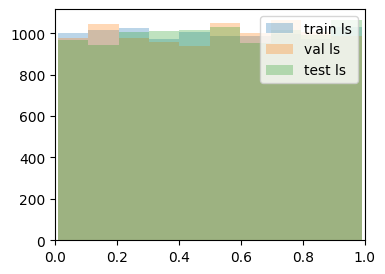

In [8]:
# check: what lengthscales are we generating? 

ls_train_set = train_set.ls
ls_val_set   = val_set.ls
ls_test_set  = test_set.ls

plt.figure(figsize=(4,3))
plt.hist(ls_train_set, alpha = 0.3, label = 'train ls') 
plt.hist(ls_val_set,   alpha = 0.3, label = 'val ls') 
plt.hist(ls_test_set,  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()


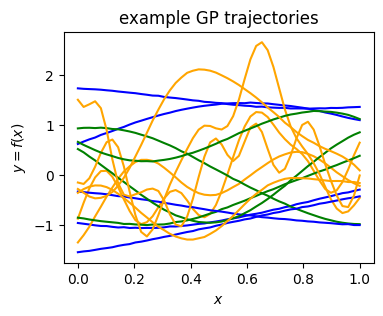

In [10]:
# check: what trajectories are we generating?

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    if train_set.ls[i] <= 0.2:
        col = 'orange'
    elif train_set.ls[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(train_set.x[i], train_set.y[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('example GP trajectories')

plt.show()

### VAE Model

In [11]:
out_dim     = args["input_dim"]
hidden_dim  = args["hidden_dim"]
latent_dim  = args["latent_dim"]
conditional = args["conditional"]
batch_size  = args["batch_size"]
num_samples = args["num_samples"]
num_epochs  = args["num_epochs"]

### Training loop

In [12]:
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        _, y, _ = batch 
        y_hat, z_mu, z_sd = model.apply({'params': params}, y) 
        rcl_loss = rcl(y_hat, y).mean()
        kld_loss = kl_divergence(z_mu, z_sd).mean()
        loss = rcl_loss + kld_loss
        return loss
    
    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads), loss_fn(state.params)

In [13]:
@jax.jit
def eval(state, batch):
    def loss_fn(params):
        _, y, _ = batch 
        y_hat, z_mu, z_sd = model.apply({'params': params}, y) 
        rcl_loss = rcl(y_hat, y).mean()
        kld_loss = kl_divergence(z_mu, z_sd).mean()
        loss = rcl_loss + kld_loss
        return loss
    
    return loss_fn(state.params)

[    1] training loss: 1549.590
[   11] training loss: 439.565
[   21] training loss: 213.343
[   31] training loss: 290.114
[   41] training loss: 165.730
[   51] training loss: 166.612
[   61] training loss: 244.674
[   71] training loss: 229.958
[   81] training loss: 179.163
[   91] training loss: 191.755
[  101] training loss: 208.258
[  111] training loss: 77.367
[  121] training loss: 182.662
[  131] training loss: 193.997
[  141] training loss: 209.497
[  151] training loss: 171.235
[  161] training loss: 115.807
[  171] training loss: 202.399
[  181] training loss: 204.474
[  191] training loss: 225.424
Training of 200 epochs took 17 seconds


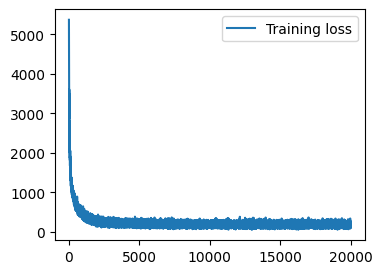

In [14]:
# define model
model = VAE(hidden_dim, latent_dim, out_dim, conditional)

# initialise parameters
key = jax.random.PRNGKey(0) 
batch_init = next(val_loader_iter) # batch[0] - x, batch[1] - y, batch[2] - c
_, y, _ = batch_init
params = model.init(key, y)['params']

# optimizer
optimizer = optax.adam(learning_rate=0.001)

# store training state
state = train_state.TrainState.create(apply_fn=model, params=params, tx=optimizer)

# check architecture
#print(model.tabulate(key, train_set.y,
#      console_kwargs={'force_terminal': False, 'force_jupyter': True}))

_loss_train = []

t_start = time.time()

for epoch in range(num_epochs):
    for _, batch_train in enumerate(train_loader):
        state, loss_train = train_step(state, batch_train)
        _loss_train.append(loss_train)

    if epoch % 10 == 0:    # print every 10 epochs
        print(f'[{epoch + 1:5d}] training loss: {loss_train:.3f}')

t_elapsed = time.time() - t_start

print(f'Training of {num_epochs} epochs took {round(t_elapsed)} seconds')

assert len(_loss_train) == num_epochs * num_samples // batch_size

plt.figure(figsize=(4,3))
plt.plot(range(len(_loss_train)), _loss_train, label = 'Training loss')
plt.legend()



[    1] training loss: 1739.323, test loss: 1475.273
[    2] training loss: 1145.883, test loss: 1357.890
[    3] training loss: 871.723, test loss: 969.240
[    4] training loss: 736.917, test loss: 758.148
[    5] training loss: 705.008, test loss: 701.520
[    6] training loss: 762.225, test loss: 650.649
[    7] training loss: 616.465, test loss: 557.292
[    8] training loss: 523.678, test loss: 526.764
[    9] training loss: 397.414, test loss: 335.302
[   10] training loss: 322.540, test loss: 431.377
[   11] training loss: 408.232, test loss: 451.563
[   12] training loss: 375.378, test loss: 285.244
[   13] training loss: 312.511, test loss: 461.865
[   14] training loss: 419.121, test loss: 371.420
[   15] training loss: 349.324, test loss: 373.620
[   16] training loss: 310.130, test loss: 242.786
[   17] training loss: 260.487, test loss: 271.509
[   18] training loss: 312.117, test loss: 225.262
[   19] training loss: 196.731, test loss: 422.500
[   20] training loss: 365.

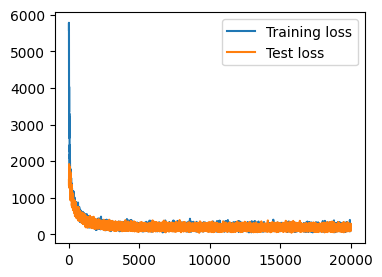

In [15]:
# WHY is this cell so much slower than the previous one?

# define model
model = VAE(hidden_dim, latent_dim, out_dim, conditional)

# initialise parameters
key = jax.random.PRNGKey(0) 
batch_init = next(val_loader_iter) # batch[0] - x, batch[1] - y, batch[2] - c
_, y, _ = batch_init
params = model.init(key, y)['params']

# optimizer
optimizer = optax.adam(learning_rate=0.001)

# store training state
state = train_state.TrainState.create(apply_fn=model, params=params, tx=optimizer)

# check architecture
#print(model.tabulate(key, train_set.y,
#      console_kwargs={'force_terminal': False, 'force_jupyter': True}))

_loss_train = []
_loss_test = []

t_start = time.time()

for epoch in range(num_epochs):
    # Training phase
    for _, batch_train in enumerate(train_loader):
        state, loss_train = train_step(state, batch_train)
        _loss_train.append(loss_train)

    # Test phase
    for _, batch_test in enumerate(test_loader):
        loss_test = eval(state, batch_test)
        _loss_test.append(loss_test)

    if epoch % 1 == 0:    # print every 10 epochs
        print(f'[{epoch + 1:5d}] training loss: {loss_train:.3f}, test loss: {loss_test:.3f}')

t_elapsed = time.time() - t_start

print(f'Training of 10 epochs took {round(t_elapsed)} seconds')

assert len(_loss_train) == num_epochs * num_samples // batch_size

plt.figure(figsize=(4,3))
plt.plot(range(len(_loss_train)), _loss_train, label = 'Training loss')
plt.plot(range(len(_loss_test)), _loss_test, label = 'Test loss')
plt.legend()

#### What have we learnt?

In [16]:
# Get trained decoder params
decoder_params = state.params['decoder']

(100, 30)
(100, 50)


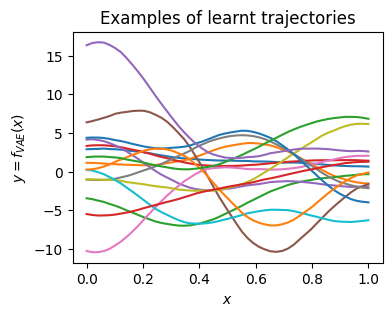

In [17]:
rng, z_rng, init_rng = random.split(key, 3)

# latents as input
z = random.normal(z_rng, (batch_size, latent_dim))
print(z.shape)

# create decoder
decoder = Decoder(hidden_dim, out_dim)

# # TODO: substitute this with decoder evaluation using trained paramters, .e.g. decoder_params = state.params
# # initiailize randomly 
# params = decoder.init(init_rng, z)['params']

# TODO: substitute this with, .e.g. out = decoder.apply({'params': decoder_params}, z)
# Apply decoder with parameters on the data
out = decoder.apply({'params': decoder_params}, z)             
print(out.shape)

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(train_set.x[0], out[i,:])
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of learnt trajectories')

plt.show()


#### Visual diagnostics

### Inference with MCMC

#### Generate data

Text(0.5, 1.0, 'Ground truth, corresponds to $ls$=0.2')

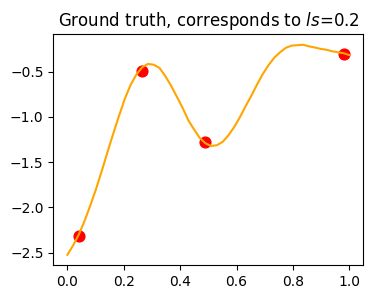

In [19]:
x = train_set[0][0]

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, x=x, jitter=1e-6, noise=True, length=args["true_ls"], var=1)

gp_draw = draws['f'].T
y_draw = draws['y'].T

# choose indices of data points for inference
obs_idx = jnp.array([2, 13, 24, 48])
y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]
plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

#### Nupmyro model

In [20]:

# import loss functions
from priorCVAE.models.mcmc import *

#mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_post, numpyro_model, args, conditional=False)

In [21]:
#predictive = Predictive(numpyro_model, mcmc_vae_samples)
#predictions_vae = predictive(rng_key_pred,  args["z_dim"], True, args["y_obs"], args["obs_idx"] )["f"]

#mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
#hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
#percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

#N_lines = 10
#plt.plot(x, gp_draw, label="ground truth", color="orange")
#plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
#plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")

#plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, label="VAE posterior: 90% BCI")

#plt.title('PriorCVAE inference')
#plt.ylim([-2, 1])